## Creating CF and ACDD compliant NetCDF file
*Author:* Corrado Motta - corradomotta92@gmail.com

This notebook aims to show how to add and possibly extract descriptive and administrative metadata from NetCDF files using python.
With descriptive metadata we mean all metadata that relates to Discovery and Identification in the FAIR principles. They usually includes info such as _title_, _author_, _subjects_, _keywords_, _publisher_, and _urls_. Examples of standards are __DataCite__, __DublinCore__, __ISO 19115__. They are mainly domain agnostic. On the other hand, administritive metadata are used to provide technical support for managing
data in a dataset. Such metadata are domain specific.

Useful links:
* [Notebook on FAIR and NetCDF](https://notebooks.githubusercontent.com/view/ipynb?color_mode=auto&commit=7438c171a8bfd838a97b9b859c8d92e0f9f01750&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f676973742f686576677972742f39663666613837383035643938636637386532356537373138616532336636622f7261772f373433386331373161386266643833386139376239623835396338643932653066396630313735302f6372656174655f4e65744344465f43465f414344442e6970796e62&logged_in=false&nwo=hevgyrt%2F9f6fa87805d98cf78e25e7718ae23f6b&path=create_NetCDF_CF_ACDD.ipynb&repository_id=99453764&repository_type=Gist)
* [Attribute Convention for Data Discovery](https://wiki.esipfed.org/Attribute_Convention_for_Data_Discovery_1-3)
* [CF Standard name table](https://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html)

In this notebook we show how to make a FAIR-compliant NECTDF file from raw data. We use two conventions to reach this goal:
* __CF__: Climate and Forecast convention. Mainly used for setting standard names to variables in NETCDF files and standard metadata for variables and dimensions.
* __ACDD__: Attribute for Climate and Data Discovery. It can be used together with CF to populate the global attributes of a .nc file. Some opensource software already exist to read the global attributes and automatically generate Dublin Core or ISO 19115 descriptive metadata.

Eventually, we also discuss how to generate/extract a XML file containg all the metadata following the ISO19115 standard schema.

### Table of Contents
* [1. Read configuration file](#read_cf)
* [2. Import raw data](#import_data)
* [3. Create NETCDF file with global metadata](#create_nc)
* [4. Read a NETCDF file and print metadata](#read_nc)
* [5. Export global metadata to ISO 19115 XML format](#export_iso)

### 1. Read configuration file <a class="anchor" id="read_cf"></a>
First of all we import all the needed packages.

In [1]:
# to read netcdf file
import netCDF4 as nc
# numpy is used to work with n-dimensional arrays
import numpy as np
# os miscellaneous
import os
# work with table
import pandas as pd
# to make figures
import matplotlib
# to work on netcdf files
import xarray
# to read conf file
import configparser
# to work with path
import ntpath
# to add date
from datetime import date
# to generate ISO19115
from bas_metadata_library.standards.iso_19115_2 import MetadataRecordConfigV2, MetadataRecord
# to read JSON database
from pysondb import PysonDB
# for iso format
from datetime import datetime

All parameters are listed in the configuration file named _conf.ini_ in the conf folder. Let's read it using python and save the parameters into variables.

In [2]:
# read the conf file
read_config = configparser.ConfigParser()
read_config.read("conf/path.ini")

# save params to variable
filePath = read_config.get("file_system_options", "raw_file_path")
resultPath = read_config.get("file_system_options", "result_path")
headerList = read_config.get("data_configuration", "header_list").split(',')

# Extract file name from the file path
filename = ntpath.split(filePath)[1].split(".")[0]

# print them 
if(filePath):
    print("Path to raw data: {0}. Extracted filename: {1}".format(filePath, filename))
else:
    print("Path not available")
if(resultPath):
    print("path to directory where to store data: {0}".format(resultPath))
else:
    print("Path not available")
    
# check if result directory exists otherwise create it
if(not os.path.exists(resultPath)):
    os.makedirs(resultPath)
    print("Created directory for storing results.")

Path to raw data: data/20220914_134036_swamp2_turning_circle_azimuth30_rpm1600_deltayaw20.csv. Extracted filename: 20220914_134036_swamp2_turning_circle_azimuth30_rpm1600_deltayaw20
path to directory where to store data: results


In [3]:
# read generated file
read_config = configparser.ConfigParser()
read_config.read("conf/conf.ini")
my_complete_dict = dict(read_config.items('mandatory_global_attributes'))
my_complete_dict = my_complete_dict | dict(read_config.items('optional_global_attributes'))

In [4]:
print("The following attributes will be added:")
cont = 0
key_list = []
for key, value in my_complete_dict.items():
    if(value):
        cont +=1
        my_complete_dict[key] = str(value).replace('"','')
        key_list.append(key)
        print(str(cont) + ".", key, '->', value)

The following attributes will be added:
1. keywords -> "unmanned marine vehicles,marine robotics,autonomous systems"
2. institution -> CNR-INM
3. platform -> SWAMP
4. title -> Naval maneuver test in Venice
5. conventions -> "ACDD-1.3,CF-1.6"
6. license -> Creative Commons
7. summary -> First test of naval maneuver in Venice. ZigZag and circle maneuvers were done using several azimuth and trhust values.
8. creator_name -> "Ferretti Roberta, Bibuli Marco, Motta Corrado"
9. product_version -> 1
10. creator_email -> "roberta.ferretti@cnr.it,marco.bibuli@cnr.it,corrado.motta@inm.cnr.it"
11. project -> INNOVAMARE
12. processing_level -> raw data


#### 1b. Checking global variables against JSON database

We want to check if the attributes specifed in the ini file satisfy the minimum set of mandatory global metadata that we stored in the JSON database, in the database folder. The JSON database is generated una tantum from a CSV table (check the "database" notebook for more information)

In [5]:
# Opening JSON file
global_db = PysonDB('database/global_metadata.json')

# iterate over mandatory global metadata. When one is not present, stop and print it
for key, value in global_db.get_all().items():
    if(value['required'] and not value['auto']):
        if(value['ACDD'].lower() in key_list):
            print(value['ACDD'] + ".. found")
        else:
            print(value['ACDD'], "NOT found!\n\nPlease add a value for ",value['ACDD'])
            break

title.. found
summary.. found
keywords.. found
Conventions.. found
creator_name.. found
creator_email.. found
institution.. found
platform.. found
license.. found
product_version.. found


### 2. Import raw data <a class="anchor" id="import_data"></a>
Let's import the data using read table method of pandas. We give as input the path, the delimiter as a single space, and the header list. We also set to not use the first column as index

In [6]:
data = pd.read_table(filePath, delimiter = ',', header=[0,1])

The shape method tell us the dimensions of the imported table. in python, you can simply check what a method does using the help function:

In [7]:
data

,date,time,latitude,longitude,projection_x_coordinate,projection_y_coordinate,horizontalAccuracy,llhPositionValidFlags,roll,pitch,...,RR_thruster_speed,FR_thruster_speed,RL_thruster_force,FL_thruster_force,RR_thruster_force,FR_thruster_force,RL_thruster_current,FL_thruster_current,RR_thruster_current,FR_thruster_current
,date,time,latitude,longitude,projection_x_coordinate,projection_y_coordinate,horizontalAccuracy,llhPositionValidFlags,platform_roll,platform_pitch,...,thruster_speed,thruster_speed,thruster_force,thruster_force,thruster_force,thruster_force,thruster_current,thruster_current,thruster_current,thruster_current
0,20220914,134036.000,45.436845,12.355075,-55.01,29.16,1.642,1,3.71,2.88,...,1603.8,1563.3,11.60,10.51,10.51,9.99,3.28,3.22,2.86,3.31
1,20220914,134036.000,45.436845,12.355075,-55.01,29.16,1.642,1,3.88,2.42,...,1611.9,1563.3,11.71,10.51,10.62,9.99,3.23,3.21,2.86,3.31
2,20220914,134036.000,45.436845,12.355075,-55.01,29.16,1.642,1,4.24,1.92,...,1611.9,1563.3,11.60,10.51,10.62,9.99,3.20,3.21,2.86,3.31
3,20220914,134036.249,45.436842,12.355073,-55.34,29.01,1.639,1,4.43,1.52,...,1611.9,1563.3,11.60,10.51,10.62,9.99,3.21,3.20,2.87,3.32
4,20220914,134036.249,45.436842,12.355073,-55.34,29.01,1.639,1,4.59,1.26,...,1595.7,1555.2,11.27,10.41,10.41,9.89,3.06,3.14,2.81,3.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759,20220914,134151.749,45.436912,12.354833,-47.56,10.29,1.513,1,2.79,2.57,...,1595.7,1620.0,12.17,11.05,10.41,10.73,3.43,3.44,2.85,3.40
760,20220914,134151.749,45.436912,12.354833,-47.56,10.29,1.513,1,3.09,2.57,...,1595.7,1620.0,12.17,11.05,10.41,10.73,3.44,3.43,2.85,3.40
761,20220914,134152.000,45.436915,12.354832,-47.23,10.22,1.511,1,3.54,2.85,...,1587.6,1620.0,12.40,11.05,10.30,10.73,3.44,3.44,2.89,3.43


let's remove the second header and save it on a dedicated list

In [8]:
data_columns = data.columns

# Remove header
data = data.droplevel(1, axis=1)

Now we create datetime objects so that we can then convert them easily to ISO 8601

In [9]:
# join date and time
data["datetime"] = data["date"].astype(str)+ " " + data["time"].astype(str)
# create a datetime python object
data["datetime"] = pd.to_datetime(data['datetime'], format='%yy%m%d %H%M%S.%s', infer_datetime_format=True)

We are ready to add all automatic global attributes.my_complete_dict

In [10]:
my_complete_dict["time_coverage_start"] = data["datetime"].min().isoformat()
my_complete_dict["time_coverage_end"] =   data["datetime"].max().isoformat()
my_complete_dict["geospatial_lat_max"] =  data['latitude'].max()
my_complete_dict["geospatial_lat_min"] =  data['latitude'].min()
my_complete_dict["geospatial_lat_units"] = "degree_north"
my_complete_dict["geospatial_lon_min"] =  data['longitude'].min()
my_complete_dict["geospatial_lon_max"] =  data['longitude'].max()
my_complete_dict["geospatial_lon_units"] = "degree_east"
my_complete_dict["date_created"] = datetime.now().isoformat()
my_complete_dict["time_coverage_duration"] = (data["datetime"].max() - data["datetime"].min()).isoformat()
my_complete_dict["time_coverage_resolution"] = "milliseconds"

# add to keylist
key_list = []
for key, value in my_complete_dict.items():
    if(value):
        key_list.append(key)

Check if any mandatory and auto global attributes are not filled yet.

In [11]:
# iterate over mandatory global metadata. When one is not present, stop and print it
for key, value in global_db.get_all().items():
    if(value['required'] and value['auto']):
        if(value['ACDD'].lower() in key_list):
            print(value['ACDD'] + ".. found")
        else:
            print(value['ACDD'], "NOT found!\n\nPlease add a value for ",value['ACDD'])
            break

time_coverage_start.. found
time_coverage_end.. found
geospatial_lat_max.. found
geospatial_lat_min.. found
geospatial_lat_units.. found
geospatial_lon_min.. found
geospatial_lon_max.. found
geospatial_lon_units.. found
date_created.. found
time_coverage_duration.. found
time_coverage_resolution.. found


Let's make a simple plot using two of the present variables. We can print all variable naimes:

In [13]:
# read all columns
data.columns

Index(['date', 'time', 'latitude', 'longitude', 'projection_x_coordinate',
       'projection_y_coordinate', 'horizontalAccuracy',
       'llhPositionValidFlags', 'roll', 'pitch', 'yaw', 'surge_velocity',
       'sway_velocity', 'heave_velocity', 'speedAccuracy', 'headingAccuracy',
       'nedVelocityValidFlags', 'roll_rate', 'pitch_rate', 'yaw_rate',
       'surge_acceleration', 'sway_acceleration', 'heave_acceleration',
       'azimuth_angle_reference', 'RL_azimuth_angle', 'FL_azimuth_angle',
       'RR_azimuth_angle', 'FR_azimuth_angle', 'thruster_speed_reference',
       'RL_thruster_speed', 'FL_thruster_speed', 'RR_thruster_speed',
       'FR_thruster_speed', 'RL_thruster_force', 'FL_thruster_force',
       'RR_thruster_force', 'FR_thruster_force', 'RL_thruster_current',
       'FL_thruster_current', 'RR_thruster_current', 'FR_thruster_current',
       'datetime'],
      dtype='object')

We can then plot the fluorescence against the depth to check wether the data looks as expected

<AxesSubplot:xlabel='latitude'>

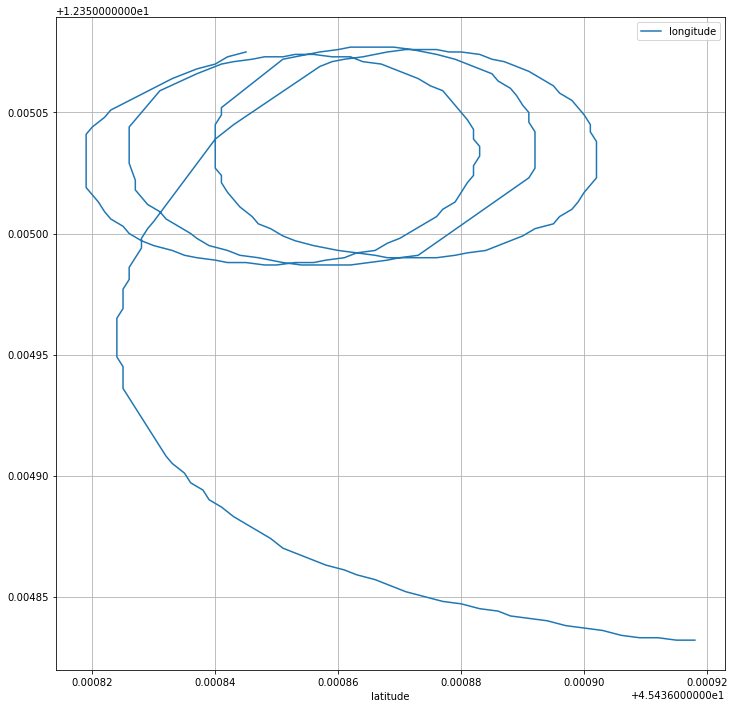

In [14]:
data.plot(x='latitude', y='longitude', figsize=(12,12), grid = True)

### 3. Create NETCDF file with global metadata <a class="anchor" id="create_nc"></a>
Now that we know the data looks OK, we can create a NETCDF out of them. We use the xarray package to do that. First we create an xarray object from the pandas data:

In [15]:
xr = xarray.Dataset.from_dataframe(data)

In [16]:
xr

<xarray.Dataset>
Dimensions:                   (index: 764)
Coordinates:
  * index                     (index) int64 0 1 2 3 4 5 ... 759 760 761 762 763
Data variables: (12/42)
    date                      (index) int64 20220914 20220914 ... 20220914
    time                      (index) float64 1.34e+05 1.34e+05 ... 1.342e+05
    latitude                  (index) float64 45.44 45.44 45.44 ... 45.44 45.44
    longitude                 (index) float64 12.36 12.36 12.36 ... 12.35 12.35
    projection_x_coordinate   (index) float64 -55.01 -55.01 ... -47.23 -46.9
    projection_y_coordinate   (index) float64 29.16 29.16 29.16 ... 10.22 10.22
    ...                        ...
    FR_thruster_force         (index) float64 9.99 9.99 9.99 ... 10.73 10.73
    RL_thruster_current       (index) float64 3.28 3.23 3.2 ... 3.44 3.43 3.4
    FL_thruster_current       (index) float64 3.22 3.21 3.21 ... 3.44 3.61 3.61
    RR_thruster_current       (index) float64 2.86 2.86 2.86 ... 2.89 2.89 2.89
    FR_thruster_current       (index) float64 3.31 3.31 3.31 ... 3.43 3.44 3.45
    datetime                  (index) datetime64[ns] 2022-09-14T13:40:36 ... ...

By printing it, we can already see that now it has assumed the format of a NETCDF file

It is time to add the __global__ metadata stored in our configuration file to the Netcdf

In [17]:
for key, value in my_complete_dict.items():
    if(value):
        xr.attrs[key] = value

Now, we can add the __attributes__ metadata to each variable to all variables that are found 

In [18]:
# Set json file

# Opening JSON file
variable_db = PysonDB('database/variable_metadata.json')

# get all data
variables = variable_db.get_all()

We also set a small function to get all metadata from the standard name

In [19]:
def getId(db, name):
    for key in db:
        if(db[key]['long_name'] == name):
            return db[key]
    return None

In [20]:
# iterate over each variable in the table and look for it in the database.
for key in data_columns:
    attr = getId(variables, key[1])
    if(attr):
        print("Attributes found for variable", key[0])
        for attr_name, value in attr.items():
            if(attr_name!='version' and value):
                xr[key[0]].attrs[attr_name] = value
    else:
        print("Attributes NOT found for variable", key[0])
print("\nAll done!")

Attributes found for variable date
Attributes found for variable time
Attributes found for variable latitude
Attributes found for variable longitude
Attributes found for variable projection_x_coordinate
Attributes found for variable projection_y_coordinate
Attributes found for variable horizontalAccuracy
Attributes found for variable llhPositionValidFlags
Attributes found for variable roll
Attributes found for variable pitch
Attributes found for variable yaw
Attributes found for variable surge_velocity
Attributes found for variable sway_velocity
Attributes found for variable heave_velocity
Attributes found for variable speedAccuracy
Attributes found for variable headingAccuracy
Attributes found for variable nedVelocityValidFlags
Attributes found for variable roll_rate
Attributes found for variable pitch_rate
Attributes found for variable yaw_rate
Attributes found for variable surge_acceleration
Attributes found for variable sway_acceleration
Attributes found for variable heave_accelera

In [21]:
# reopen xr
xr

<xarray.Dataset>
Dimensions:                   (index: 764)
Coordinates:
  * index                     (index) int64 0 1 2 3 4 5 ... 759 760 761 762 763
Data variables: (12/42)
    date                      (index) int64 20220914 20220914 ... 20220914
    time                      (index) float64 1.34e+05 1.34e+05 ... 1.342e+05
    latitude                  (index) float64 45.44 45.44 45.44 ... 45.44 45.44
    longitude                 (index) float64 12.36 12.36 12.36 ... 12.35 12.35
    projection_x_coordinate   (index) float64 -55.01 -55.01 ... -47.23 -46.9
    projection_y_coordinate   (index) float64 29.16 29.16 29.16 ... 10.22 10.22
    ...                        ...
    FR_thruster_force         (index) float64 9.99 9.99 9.99 ... 10.73 10.73
    RL_thruster_current       (index) float64 3.28 3.23 3.2 ... 3.44 3.43 3.4
    FL_thruster_current       (index) float64 3.22 3.21 3.21 ... 3.44 3.61 3.61
    RR_thruster_current       (index) float64 2.86 2.86 2.86 ... 2.89 2.89 2.89
    FR_thruster_current       (index) float64 3.31 3.31 3.31 ... 3.43 3.44 3.45
    datetime                  (index) datetime64[ns] 2022-09-14T13:40:36 ... ...
Attributes: (12/23)
    keywords:                  unmanned marine vehicles,marine robotics,auton...
    institution:               CNR-INM
    platform:                  SWAMP
    title:                     Naval maneuver test in Venice
    conventions:               ACDD-1.3,CF-1.6
    date_created:              2022-09-15T16:30:21.075151
    ...                        ...
    geospatial_lat_units:      degree_north
    geospatial_lon_min:        12.354832
    geospatial_lon_max:        12.355077
    geospatial_lon_units:      degree_east
    time_coverage_duration:    P0DT0H1M16.249S
    time_coverage_resolution:  milliseconds

Now we can save it as a NETCDF with the following function:

In [22]:
# create a result path for it
result_path = os.path.join(resultPath, filename + ".nc")

# save to nc
xr.to_netcdf(result_path)
print("saved to {0}".format(result_path))

saved to results\20220914_134036_swamp2_turning_circle_azimuth30_rpm1600_deltayaw20.nc


### 4. Read a NETCDF file and print metadata <a class="anchor" id="read_nc"></a>
To read the NETCDF we use the homonym python package

In [23]:
ds = nc.Dataset(result_path)
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    keywords: unmanned marine vehicles,marine robotics,autonomous systems
    institution: CNR-INM
    platform: SWAMP
    title: Naval maneuver test in Venice
    conventions: ACDD-1.3,CF-1.6
    date_created: 2022-09-15T16:30:21.075151
    license: Creative Commons
    summary: First test of naval maneuver in Venice. ZigZag and circle maneuvers were done using several azimuth and trhust values.
    creator_name: Ferretti Roberta, Bibuli Marco, Motta Corrado
    product_version: 1
    creator_email: roberta.ferretti@cnr.it,marco.bibuli@cnr.it,corrado.motta@inm.cnr.it
    project: INNOVAMARE
    processing_level: raw data
    time_coverage_start: 2022-09-14T13:40:36
    time_coverage_end: 2022-09-14T13:41:52.249000
    geospatial_lat_max: 45.436918
    geospatial_lat_min: 45.436819
    geospatial_lat_units: degree_north
    geospatial_lon_min: 12.354832
    geospatial_lon_max: 12.355077
    geospatial

As an alternative we can use xarray as well

In [24]:
ds_disk = xarray.open_dataset(result_path)

In [25]:
ds_disk

<xarray.Dataset>
Dimensions:                   (index: 764)
Coordinates:
  * index                     (index) int64 0 1 2 3 4 5 ... 759 760 761 762 763
Data variables: (12/42)
    date                      (index) int64 ...
    time                      (index) float64 ...
    latitude                  (index) float64 ...
    longitude                 (index) float64 ...
    projection_x_coordinate   (index) float64 ...
    projection_y_coordinate   (index) float64 ...
    ...                        ...
    FR_thruster_force         (index) float64 ...
    RL_thruster_current       (index) float64 ...
    FL_thruster_current       (index) float64 ...
    RR_thruster_current       (index) float64 ...
    FR_thruster_current       (index) float64 ...
    datetime                  (index) datetime64[ns] ...
Attributes: (12/23)
    keywords:                  unmanned marine vehicles,marine robotics,auton...
    institution:               CNR-INM
    platform:                  SWAMP
    title:                     Naval maneuver test in Venice
    conventions:               ACDD-1.3,CF-1.6
    date_created:              2022-09-15T16:30:21.075151
    ...                        ...
    geospatial_lat_units:      degree_north
    geospatial_lon_min:        12.354832
    geospatial_lon_max:        12.355077
    geospatial_lon_units:      degree_east
    time_coverage_duration:    P0DT0H1M16.249S
    time_coverage_resolution:  milliseconds

Let's print the available global attributes

In [26]:
for key, value in ds_disk.attrs.items() :
    print(key + ": " + str(value))

keywords: unmanned marine vehicles,marine robotics,autonomous systems
institution: CNR-INM
platform: SWAMP
title: Naval maneuver test in Venice
conventions: ACDD-1.3,CF-1.6
date_created: 2022-09-15T16:30:21.075151
license: Creative Commons
summary: First test of naval maneuver in Venice. ZigZag and circle maneuvers were done using several azimuth and trhust values.
creator_name: Ferretti Roberta, Bibuli Marco, Motta Corrado
product_version: 1
creator_email: roberta.ferretti@cnr.it,marco.bibuli@cnr.it,corrado.motta@inm.cnr.it
project: INNOVAMARE
processing_level: raw data
time_coverage_start: 2022-09-14T13:40:36
time_coverage_end: 2022-09-14T13:41:52.249000
geospatial_lat_max: 45.436918
geospatial_lat_min: 45.436819
geospatial_lat_units: degree_north
geospatial_lon_min: 12.354832
geospatial_lon_max: 12.355077
geospatial_lon_units: degree_east
time_coverage_duration: P0DT0H1M16.249S
time_coverage_resolution: milliseconds


We can also define a simple function to read a single attribute on demand and one to return a variable object.

In [27]:
def getAttribute(myds, attribute):
    # return the value of the attribute given as argument
    
    my_attr = None
    try:
         my_attr = getattr(myds, attribute)
    except AttributeError as e: 
        print("arg <{0}> not present in the .nc file".format(attribute))
    return my_attr

def getVariable(myds, variable):
    # return the object of the variable given as argument
    return myds.variables.get(variable, None)
        

In [28]:
# geospatial_lat_max
my_attr = "summary"
print(getAttribute(ds, my_attr))

First test of naval maneuver in Venice. ZigZag and circle maneuvers were done using several azimuth and trhust values.


Let's check all variable names

In [29]:
list(ds.variables.keys())

['index',
 'date',
 'time',
 'latitude',
 'longitude',
 'projection_x_coordinate',
 'projection_y_coordinate',
 'horizontalAccuracy',
 'llhPositionValidFlags',
 'roll',
 'pitch',
 'yaw',
 'surge_velocity',
 'sway_velocity',
 'heave_velocity',
 'speedAccuracy',
 'headingAccuracy',
 'nedVelocityValidFlags',
 'roll_rate',
 'pitch_rate',
 'yaw_rate',
 'surge_acceleration',
 'sway_acceleration',
 'heave_acceleration',
 'azimuth_angle_reference',
 'RL_azimuth_angle',
 'FL_azimuth_angle',
 'RR_azimuth_angle',
 'FR_azimuth_angle',
 'thruster_speed_reference',
 'RL_thruster_speed',
 'FL_thruster_speed',
 'RR_thruster_speed',
 'FR_thruster_speed',
 'RL_thruster_force',
 'FL_thruster_force',
 'RR_thruster_force',
 'FR_thruster_force',
 'RL_thruster_current',
 'FL_thruster_current',
 'RR_thruster_current',
 'FR_thruster_current',
 'datetime']

And print a single variable

In [30]:
my_var = "ctd305O2Ppm"
obj_var = getVariable(ds, my_var)
obj_var

In [31]:
my_var = "ctd305Temperature"
obj_var = getVariable(ds, my_var)
obj_var

### 4. Export global metadata to ISO 19115 XML format <a class="anchor" id="export_iso"></a>

The metadata set in the conf.ini file are then added to the NETCDF4 using ACDD. However, we also want to be able to generate a ISO 199115 compliant metadata file, in the XML format. In fact, this is required by many different online repositories. 

Mapping between ACDD and ISO 19115 is provided [here](https://wiki.esipfed.org/Attribute_Convention_for_Data_Discovery_Mappings).

__Note:__ this is under development. Right now, a python software packet named [bas-metadata-library](https://pypi.org/project/bas-metadata-library/) is used to generate the ISO file. This is done from the conf.ini list and not directly from the NETCDF4, which would be a more auspicable solution.

In [32]:
# set contact
if(my_complete_dict["creator_name"]):
    individual_contact = [{"individual": {"name": my_complete_dict["creator_name"]}, "role": ["originator"]}]
else:
    print("not implemented yet")
    
    
minimal_record_config = {
    "hierarchy_level": "dataset",
    "metadata": {
        "language": "eng",
        "character_set": "utf-8",
        "contacts": individual_contact,
        "date_stamp": date(2018, 10, 18),
    },
    "identification": {
        "title": {"value": my_complete_dict['title']},
        "dates": {"creation": {"date": date(2018, 1, 1), "date_precision": "year"}},
        "abstract": my_complete_dict['summary'],
        "keywords":[{"terms":[{"term": item} for item in my_complete_dict['keywords'].split(",")]}],
        "character_set": "utf-8",
        "language": "eng",
        "topics": ["geoscientificInformation"],
        "extent": {
            "geographic": {
                "bounding_box": {
                    "west_longitude": -45.61521,
                    "east_longitude": -27.04976,
                    "south_latitude": -68.1511,
                    "north_latitude": -54.30761,
                }
            }
        },
    },
}
configuration = MetadataRecordConfigV2(**minimal_record_config)
record = MetadataRecord(configuration=configuration)
document = record.generate_xml_document()

# output document
result_path = os.path.join(resultPath, filename + "_metadata.xml")
# print(document.decode())
f = open(result_path, "w")
f.write(document.decode())
f.close()
print("metadata saved in", result_path)

metadata saved in results\20220914_134036_swamp2_turning_circle_azimuth30_rpm1600_deltayaw20_metadata.xml
